In [38]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [39]:
config_tsr = yaml2dict('./config/tsr_decomposition', attrdict=True).data
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).data
config = AttrDict({
    **config_tsr,
    "geodstap_data": AttrDict({**config_geodstap})
})
config

```json
{ 'data_nb': './geodstap_tsr_data.ipynb',
  'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
  'geodstap_data': { 'ap_config': './config/geoap.yaml',
                     'data_nb': './geodstap_data.ipynb',
                     'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
                     'dst_config': './config/geodst.yaml',
                     'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'},
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
  'tsa_model': 'additive'}
```

In [40]:
df = load_object(config.df_save_path) 
df_geodstap = load_object(config.geodstap_data.df_save_path)
model_data = torch.load("models/best/best_model_tsr_geodstap.pth")

data_columns = model_data['data_columns']
components = model_data['components']
lookback = model_data['lookback']
horizon = model_data['horizon']
models = model_data['models']
df

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


In [41]:
def get_forecast_tensor(component:str, lookback_data):
    return torch.tensor(lookback_data.values.T).float().unsqueeze(0).cpu()

In [42]:
with torch.no_grad():
    predictions = torch.zeros((1, len(data_columns), horizon))
    for component, model in models.items():
        lookback_data = df[[column + f"_{component}" for column in data_columns]].iloc[-(lookback+horizon):-horizon]
        model.cpu().eval()
        predictions += model(get_forecast_tensor(component, lookback_data))

preds_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
true_df = df_geodstap[df_geodstap.Datetime > df_geodstap.Datetime.max()-pd.DateOffset(hours=horizon*3)]

In [43]:
def plot_predictions_performance(true_df, preds_df):
    """
    Plot the performance of the predictions compared to the true values.
    
    Parameters
    ----------
    true_df : pd.DataFrame
        DataFrame containing the true values.
    preds_df : pd.DataFrame
        DataFrame containing the predicted values
    """
    true_df = true_df.copy()
    preds_df = preds_df.copy()

    # Align preds_df with true_df by setting Date as index in true_df
    true_df.set_index('Datetime', inplace=True)

    # Assuming preds_df has the same index as true_df (if not, align them accordingly)
    preds_df.index = true_df.index

    # Number of columns to plot
    num_rows = len(preds_df.columns)

    # Create subplots
    fig, axes = plt.subplots(num_rows, 1, figsize=(16, 6 * num_rows), sharex=True)

    # Plot each column
    for i, column in enumerate(preds_df.columns):
        if len(preds_df.columns) == 1:
            ax = axes
        else:     
            ax = axes[i]
        
        # Plot true values with points
        ax.plot(true_df.index, true_df[column], label='True', color='black', marker='o')
        
        # Plot predicted values with points
        ax.plot(preds_df.index, preds_df[column], label='Predicted', color='green', marker='o')
        
        # Add ribbon
        overestimate = preds_df[column] > true_df[column]
        underestimate = preds_df[column] <= true_df[column]
        
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=overestimate, facecolor='red', alpha=0.2, interpolate=True, label='Overestimated')
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=underestimate, facecolor='blue', alpha=0.2, interpolate=True, label='Underestimated')
        
        # Annotate points with values
        for x, y in zip(true_df.index, true_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8) 
        for x, y in zip(preds_df.index, preds_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8) 

        ax.set_title(f'Comparison of true and predicted values for {column}')
        ax.set_ylabel('SFU')
        ax.legend()

        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # Locate dates at 12:00:00
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y (%a)'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Set minor ticks' labels to only show every 4 hours
        def format_func(x, pos):
            dt = mdates.num2date(x)  # Convert the numeric value to a datetime object
            if dt.hour % 4 == 0:
                return dt.strftime('%H:%M')
            return ''
        
        ax.xaxis.set_minor_formatter(plt.FuncFormatter(format_func))

        plt.setp(ax.xaxis.get_majorticklabels(), ha='right',rotation=30, fontsize=10, fontweight='bold')
        plt.setp(ax.xaxis.get_minorticklabels(), ha='right',rotation=30, fontsize=8)


    plt.show()

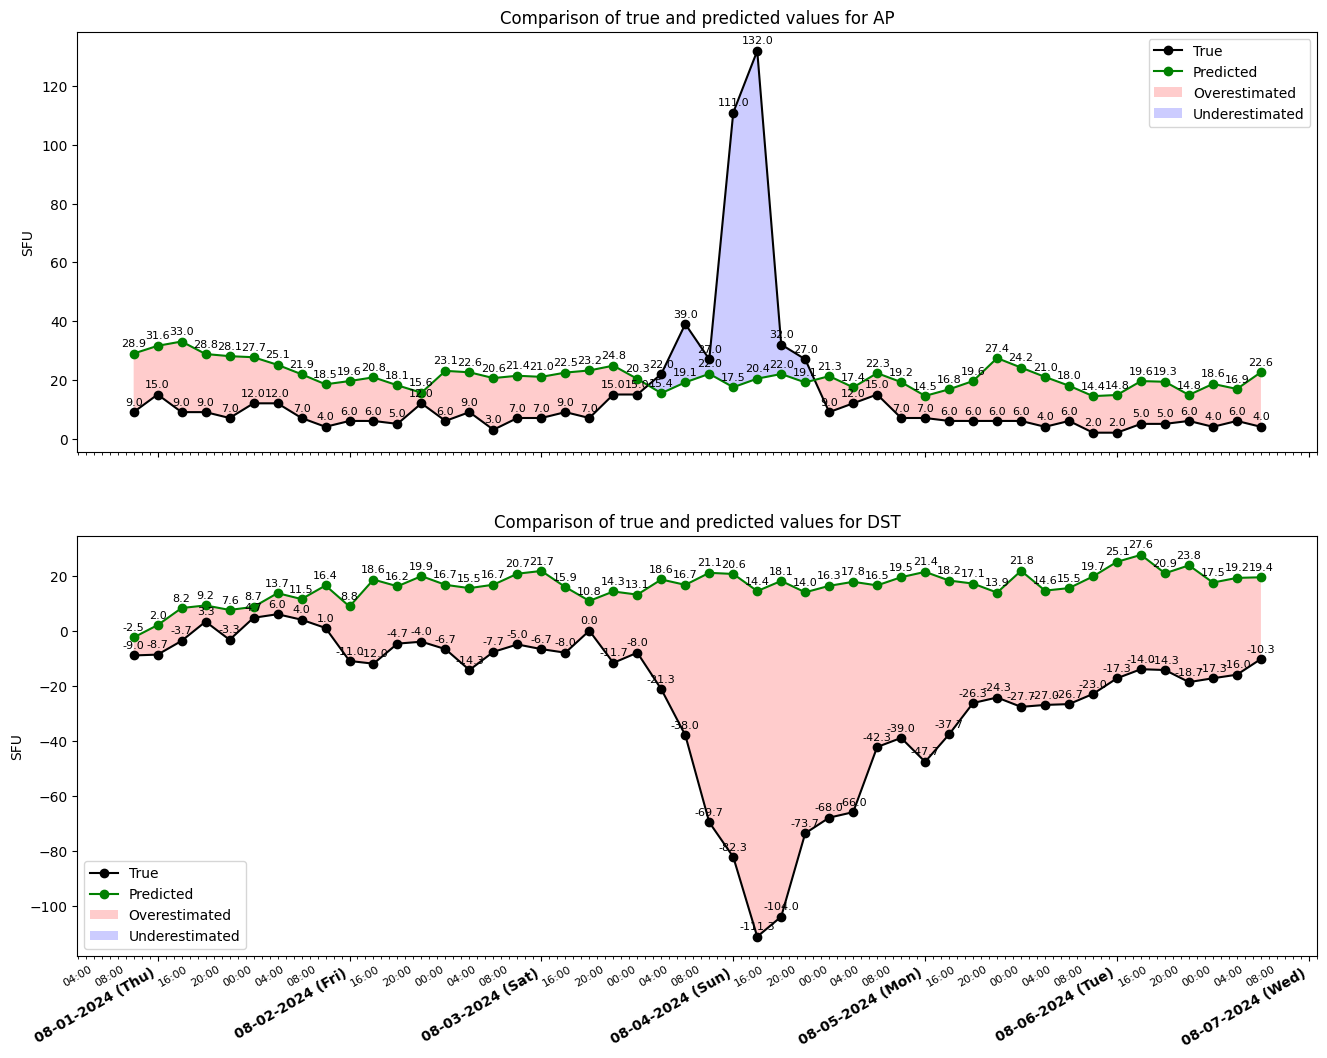

In [44]:
plot_predictions_performance(true_df, preds_df)

Timestamp('2024-08-07 06:00:00')

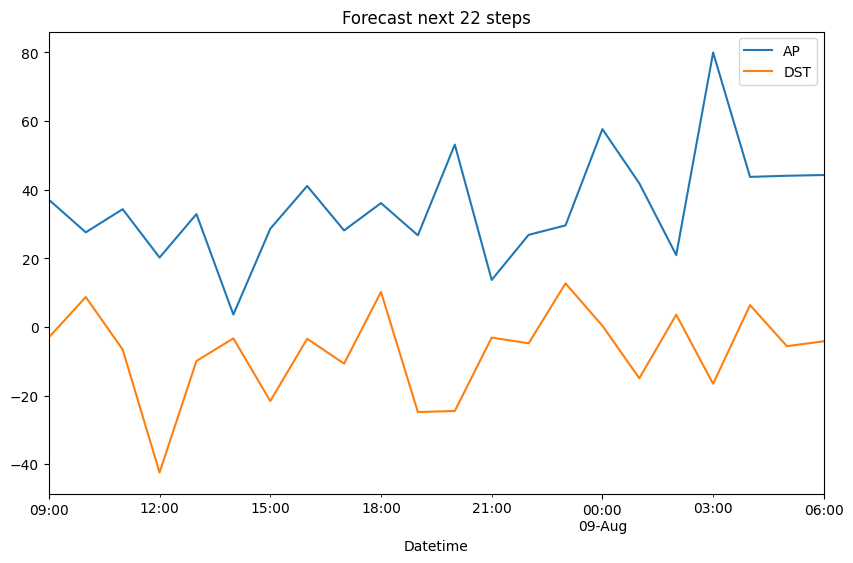

In [45]:
steps_to_forecast = 22
to_forecast_df = df.iloc[-lookback:]

def recurent_forecasting(df, days_to_forecast=12):
    to_forecast_df = df_geodstap.copy()
    forecasted_days = 0

    while forecasted_days < days_to_forecast:
        lookback_data = to_forecast_df[data_columns].iloc[-lookback:]

        with torch.no_grad():
            predictions = torch.zeros((1, len(data_columns), horizon))
            for component, model in models.items():
                model.eval()
                predictions += model(get_forecast_tensor(component, lookback_data))
    
        dates = [to_forecast_df.Datetime.max() + dt.timedelta(hours=j) for j in range(1, horizon+1)]
        pred_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
        pred_df['Datetime'] = dates
        to_forecast_df = pd.concat([to_forecast_df, pred_df], axis=0, ignore_index=True).reset_index(drop=True)
        
        forecasted_days += len(dates)
    
    return to_forecast_df

forecasts = recurent_forecasting(to_forecast_df, steps_to_forecast)
forecasts.iloc[-steps_to_forecast:].plot(x='Datetime', y=data_columns, figsize=(10, 6), title=f'Forecast next {steps_to_forecast} steps')
    


df.Datetime.max()

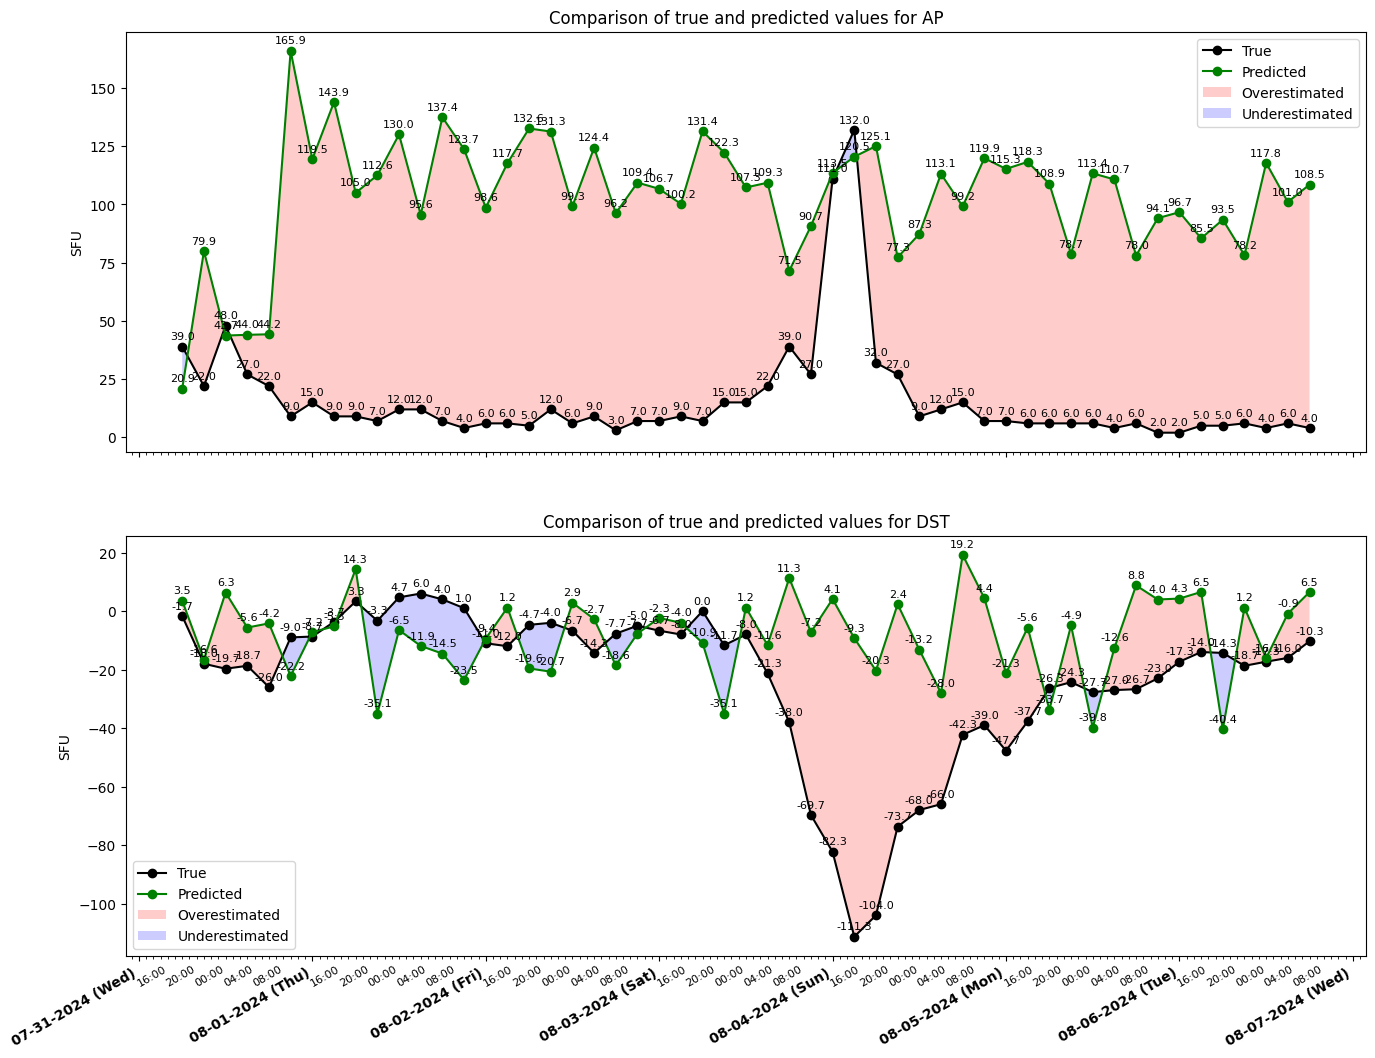

In [46]:
steps_to_forecast = 50

to_forecast_df = df.iloc[-(lookback+steps_to_forecast):-steps_to_forecast]

preds_df = recurent_forecasting(to_forecast_df, steps_to_forecast)[data_columns].iloc[-(steps_to_forecast+3):]
true_df = df_geodstap[data_columns + ['Datetime']].iloc[-(steps_to_forecast + 3):]
plot_predictions_performance(true_df, preds_df)

In [50]:
def get_forecast_tensor_by_dates(condition:str, start_date:pd.Timestamp, end_date:pd.Timestamp):
    measeures_per_day = 8

    lookback_days = lookback/measeures_per_day
    horizon_days = horizon/measeures_per_day

    data_columns = [data_column + f"_{condition}" for data_column in ['AP', 'DST']]

    X, y = prepare_forecasting_data(df[(df.Datetime >= start_date - dt.timedelta(days=lookback_days+horizon_days))
                                        & (df.Datetime <= end_date + dt.timedelta(days=horizon_days))], 
                                    fcst_history=lookback, 
                                    fcst_horizon=horizon,
                                    x_vars=data_columns, 
                                    y_vars=data_columns)
    
    X_tensor = torch.from_numpy(X).float()
    return X_tensor.cpu()


start_date = pd.Timestamp('2024-05-10')
end_date = pd.Timestamp('2024-05-17')

with torch.no_grad():
    preds = None
    for component, model in models.items():
        X = get_forecast_tensor_by_dates(component, start_date, end_date)
        if preds is None: 
            preds = torch.zeros((X.shape[0], len(data_columns), horizon))
        
        model.cpu().eval()
        preds += model(X)


true_df = df_geodstap[(df_geodstap.Datetime >= start_date) & (df_geodstap.Datetime <= end_date)] 
preds[:,0:1,:].shape


torch.Size([106, 1, 48])

In [52]:
def plot_histogram_with_preds_accuracy(true_df:pd.DataFrame, preds:torch.Tensor, data_column:str):
    steps, _, horizon = preds.shape    

    # Heatmap data with shape (horizon+lookback.length, horizon.length)
    pred_matrix = np.zeros((steps-horizon,horizon))

    # What prediction was made for the same hour of the day, j*3 number of hour ago.
    for i in range(horizon,(steps-horizon)+horizon): # 7 days
        for j in range(horizon): # 3 days
            pred_matrix[i-horizon,j] = preds[i-j, 0, j].cpu().numpy()

    heatmap_data = pred_matrix[1:,:] - true_df[data_column].values.reshape((steps-horizon)-1,1)

    # heatmap_data = (preds.cpu() - y)[:,0]

    # Line plot data
    ap = true_df[data_column]
    dates = true_df['Datetime']

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Transpose heatmap data for imshow (so it matches the orientation of dates x forecast_periods)
    heatmap_data = heatmap_data.T

    # Create the heatmap
    cax = ax1.imshow(heatmap_data, extent=[dates.iloc[0], dates.iloc[-1], horizon, 1],
                    aspect='auto', cmap='RdBu_r', vmin=-300, vmax=400)

    # Create colorbar
    cbar = fig.colorbar(cax, ax=ax1)
    cbar.set_label('$\delta_{ap}$')

    # Set labels for the heatmap
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Forecast Period (3 hours)')
    ax1.set_title('Forecast Plot')

    # Customize x-axis ticks
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    ax1.tick_params(axis='x', which='major', labelsize=10)
    ax1.tick_params(axis='x', which='minor', labelsize=8, rotation=90)
    plt.setp(ax1.get_xticklabels(), rotation=90)

    # Create a second y-axis for the line plot
    ax2 = ax1.twinx()
    ax2.plot(dates, ap, color='k', linewidth=1.5)

    # Set labels for the line plot
    ax2.set_ylabel(data_column, color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    plt.show()



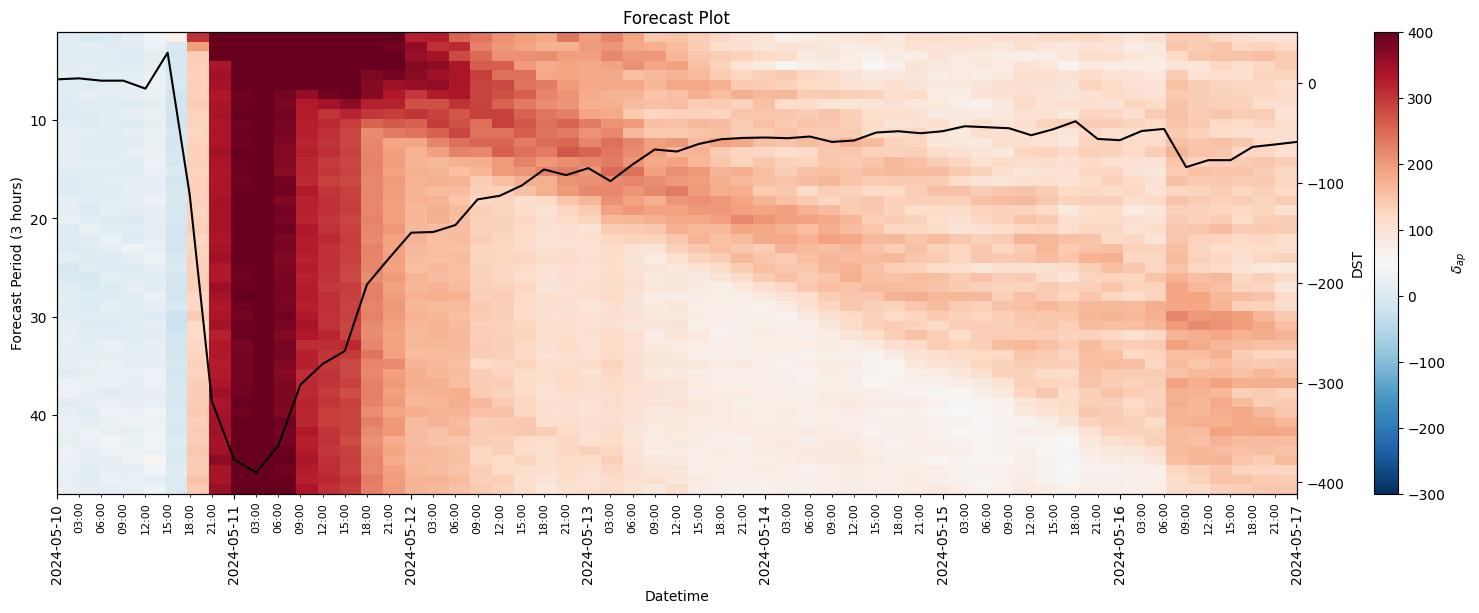

In [53]:
plot_histogram_with_preds_accuracy(true_df, preds[:,0:1,:], 'DST')

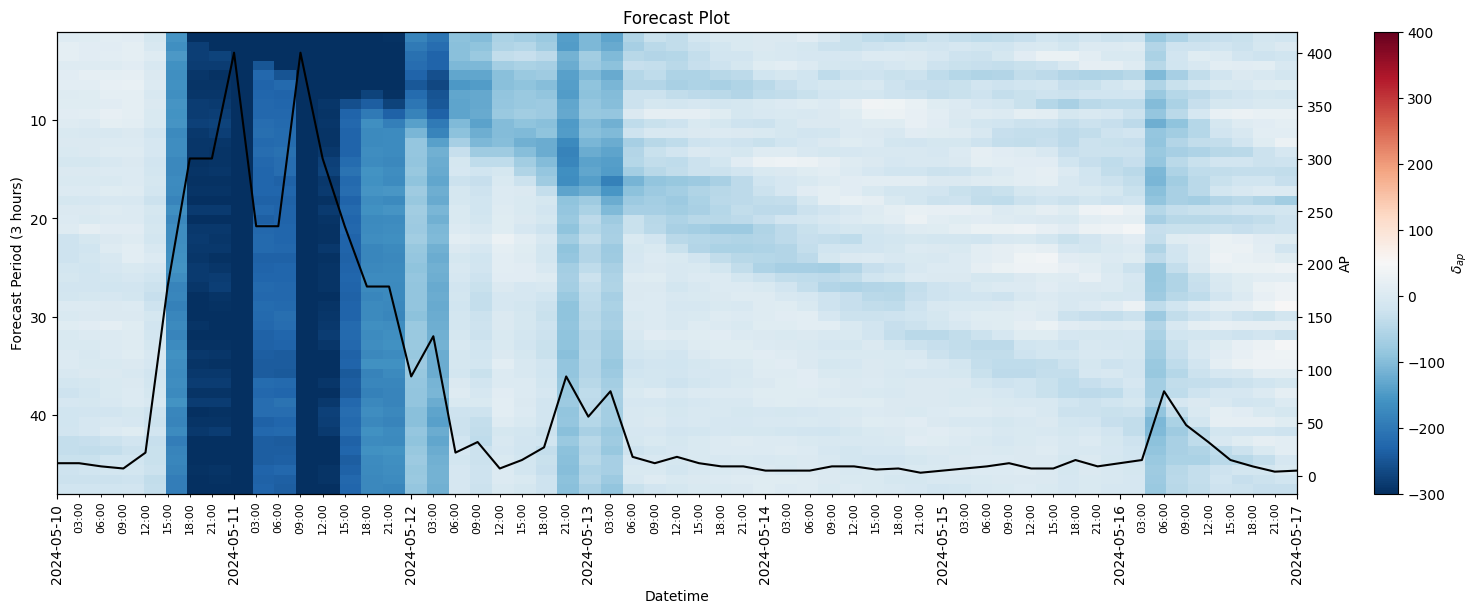

In [54]:
plot_histogram_with_preds_accuracy(true_df, preds[:,1:2,:], 'AP')